# Анализ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
# Предобработка
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler 
# Обучение
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV 
# Тест
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, mean_absolute_error, f1_score, roc_curve, roc_auc_score, auc
# индикатор важности признаков
from sklearn.ensemble import RandomForestClassifier
# Machine learning models. Модели для объединения
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# Model evaluation. Алгоритм объединения
from sklearn.ensemble import VotingClassifier

# Модели для сравнения
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# Remove warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
file_path = 'chd_addmit_300.xlsx'
data = pd.read_excel(file_path)
data.head()

,admittion,discharge,sex,height,weight,BMI,BSA,birth,Операции (все в ИБ),Перенесенные опер. (из Анамн.),...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,2016-12-12,2017-01-10,m,76,9.70,111.27,0.46,02.01.2016,12.12.2016: (Откр./ИК) Перевязка ранее наложен...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-13,2017-02-01,f,67,7.34,89.67,0.37,02.02.2016,18.01.2017: (Откр./ИК) Радикальная коррекция д...,15.08.2016г.: Транслюминальная балонная вальву...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-17,2017-02-09,m,74,8.90,103.46,0.43,21.02.2016,19.01.2017: (Откр./ИК) Перевязка ранее наложен...,29.02.2016 - подключично-легочный анастомоз сп...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-20,2017-02-21,f,67,6.97,85.15,0.36,02.03.2016,23.01.2017: (Откр./ИК) Наложение двустороннего...,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-02-13,2017-03-01,m,82,9.29,102.59,0.46,08.03.2016,15.02.2017: (Откр./ИК) Реконструкция путей отт...,13.04.2016. НАЗВАНИЕ ОПЕРАЦИИ: Транслюминальна...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


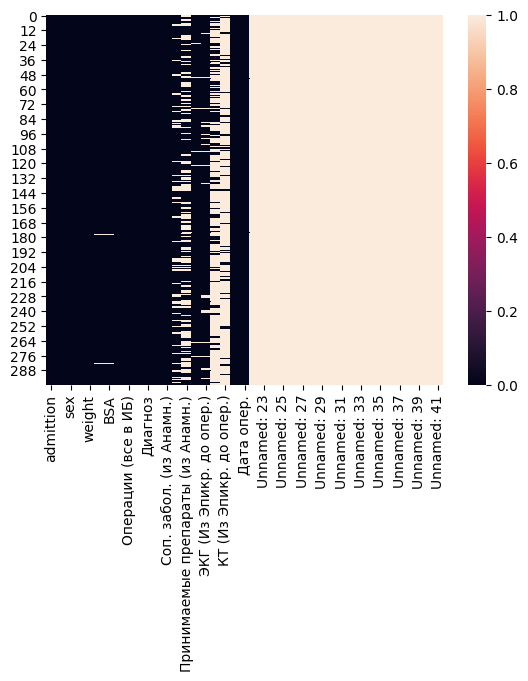

In [3]:
sns.heatmap(data.drop('target',axis=1).isnull())
plt.show()

In [4]:
data.dtypes

admittion                                          datetime64[ns]
discharge                                          datetime64[ns]
sex                                                        object
height                                                      int64
weight                                                    float64
BMI                                                       float64
BSA                                                       float64
birth                                                      object
Операции (все в ИБ)                                        object
Перенесенные опер. (из Анамн.)                             object
Диагноз                                                    object
МКБ                                                        object
Соп. забол. (из Анамн.)                                    object
Медикам. леч. по поводу осн. забол. (из Анамн.)            object
Принимаемые препараты (из Анамн.)                          object
ЭхоКГ (Из 

In [5]:
data.target.value_counts()

0    286
1     14
Name: target, dtype: int64

# Предобработка.

In [7]:
operation_type_regular_expr = r'\(([a-zA-Zа-яА-ЯёЁ0-9_.-/ ]+)\)'

def get_first_operation_type(text):
    return re.search(operation_type_regular_expr, text).group(1)

get_first_operation_type(data['Операции (все в ИБ)'][0])

'Откр./ИК'

In [13]:
data['operation_type'] = data['Операции (все в ИБ)'].apply(get_first_operation_type)
data['operation_type'].unique()

array(['Откр./ИК', 'Эндоваск.', 'Закрыт.'], dtype=object)

In [14]:
# Делаем заглушки
for col in data.columns.tolist():
  if data[col].dtypes in ['float64', 'int64']:
    data[col] = data[col].fillna(data[col].median())

col = 'sex'
data[col] = data[col].fillna(data[col].value_counts().index[0])

for col in data.columns.tolist():
  if data[col].dtypes == 'object':
    data[col] = data[col].fillna('Нет данных')

In [15]:
data = data.loc[:, ['sex','height','weight','BMI','BSA', 'target', 'operation_type']]

In [16]:
# Feature Transformation. Converting all features.
# Reversing str to num dtype via LabelEncoder
for col in data.drop('target', axis=1).dtypes[(data.dtypes == 'object') 
                                              | (data.dtypes == 'category')].index.tolist():
    data[col] = LabelEncoder().fit_transform(data[col])

# Разбьем данные на обучающую и валидационную выборки в соотношении 75:25
y = data['target']
X = data.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

# Cтандартизация данных
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)
display(X_train)

,sex,height,weight,BMI,BSA,operation_type
99,0,73,7.000,81.93,0.38,1
119,1,54,4.408,59.99,0.26,1
221,0,61,4.322,55.34,0.27,1
37,0,69,7.595,91.43,0.38,1
232,0,44,2.971,43.81,0.20,2
...,...,...,...,...,...,...
8,1,79,9.200,103.51,0.45,2
73,0,70,7.740,92.51,0.39,0
118,1,58,3.240,42.54,0.23,2
189,0,55,5.740,77.40,0.30,2


# Модель

## Важность признаков

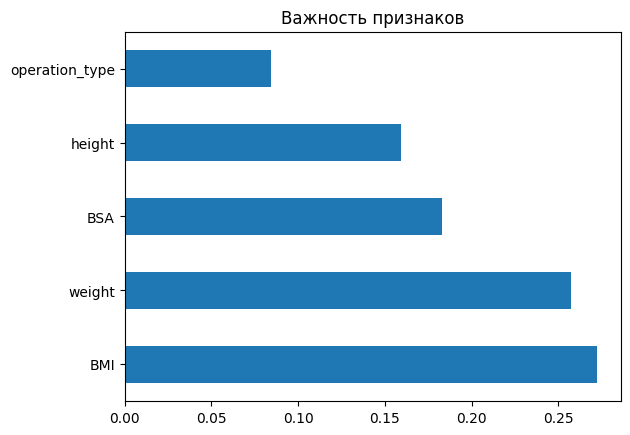

In [17]:
# Важность признаков
best_rf = RandomForestClassifier(random_state = 5).fit(X_train,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
feat_importance_names = feat_importances[feat_importances>0].sort_values(ascending=False).index.tolist()
feat_importances.nlargest().plot(kind='barh')
plt.title('Важность признаков')
plt.show()

## Обучение

In [18]:
%%time
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 5)
best_clf_svc = clf_svc.fit(X_train_scale,y_train)
best_clf_svc.best_params_

Fitting 5 folds for each of 55 candidates, totalling 275 fits
CPU times: total: 219 ms
Wall time: 33.4 s


{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [19]:
%%time
cb = CatBoostClassifier(silent=True)
param_grid = {'depth': [6,7,8,9,10],
#              'max_bin': [None,32,46,100,254],
#              'l2_leaf_reg': [None,2,10,20,30],
#              'bagging_temperature': [None,0,0.5,1],
#              'random_strength': [None,1,5,10]
              }
clf_cb = GridSearchCV(cb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 5)
best_clf_cb = clf_cb.fit(X_train_scale,y_train)
best_clf_cb.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 3.86 s
Wall time: 16.6 s


{'depth': 6}

In [20]:
%%time
xb = XGBClassifier(probability=True)
param_grid = {'max_depth': [3, 4, 5],
#              'learning_rate': [0.1, 0.2, 0.3],
#              'n_estimators': [50, 100, 150],
#              'gamma': [0, 0.1, 0.2],
#              'min_child_weight': [0, 0.5, 1],
 #             'subsample': [0.7, 0.8, 0.9, 1],
#              'colsample_bytree': [0.6, 0.8, 1],
#              'reg_alpha': [0, 1e-2, 1, 1e1],
#              'reg_lambda': [0, 1e-2, 1, 1e1]
              }
clf_xb = GridSearchCV(xb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = 5)
best_clf_xb = clf_xb.fit(X_train_scale,y_train)
best_clf_xb.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[16:36:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

CPU times: total: 141 ms
Wall time: 217 ms


{'max_depth': 3}

## Голосование

In [21]:
%%time

N = 5
cv = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

# голосование моделей SVC, CatBoostClassifier, XGBClassifier
classifiers = []
classifiers.append(best_clf_svc.best_estimator_)
classifiers.append(best_clf_cb.best_estimator_)
classifiers.append(best_clf_xb.best_estimator_)

estimators = []
for classifier in classifiers:
    estimators.append((str(classifier)[:-2], classifier))

voting_clf_soft = VotingClassifier(estimators = estimators, voting = 'soft')

y_train = y_train.reset_index(drop=True)
# predict_proba
probs = pd.DataFrame()
for fold, (trn_idx, val_idx) in enumerate(cv.split(X_train_scale, y_train), 1):    
    # учим единую модель
    voting_clf_soft.fit(X_train_scale[trn_idx], y_train[trn_idx])
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = voting_clf_soft.predict_proba(X_test_scale)[:, 1]
    
probs['1'] = probs.sum(axis=1) / N
probs['pred'] = probs['1'].apply(lambda x: 1 if x>=0.5 else 0)

display(probs)

[16:36:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

[16:36:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

[16:36:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

[16:36:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

[16:36:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not us

,Fold_1_Prob_1,Fold_2_Prob_1,Fold_3_Prob_1,Fold_4_Prob_1,Fold_5_Prob_1,1,pred
0,0.028290,0.026292,0.025696,0.022318,0.018266,0.024172,0
1,0.031477,0.029219,0.034355,0.022048,0.021693,0.027758,0
2,0.040416,0.048120,0.031300,0.030061,0.029675,0.035914,0
3,0.026930,0.024835,0.024717,0.020227,0.018528,0.023047,0
4,0.027775,0.090031,0.024941,0.035203,0.042211,0.044032,0
...,...,...,...,...,...,...,...
70,0.024992,0.023704,0.022905,0.019554,0.015789,0.021389,0
71,0.035367,0.028539,0.033192,0.026065,0.017887,0.028210,0
72,0.027498,0.026978,0.025113,0.022041,0.021832,0.024692,0
73,0.027517,0.026375,0.027577,0.019894,0.014409,0.023155,0


CPU times: total: 18.4 s
Wall time: 3.84 s


## Модели

[16:36:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

[16:36:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

[16:36:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

[16:36:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not used.

[16:36:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "probability" } are not us

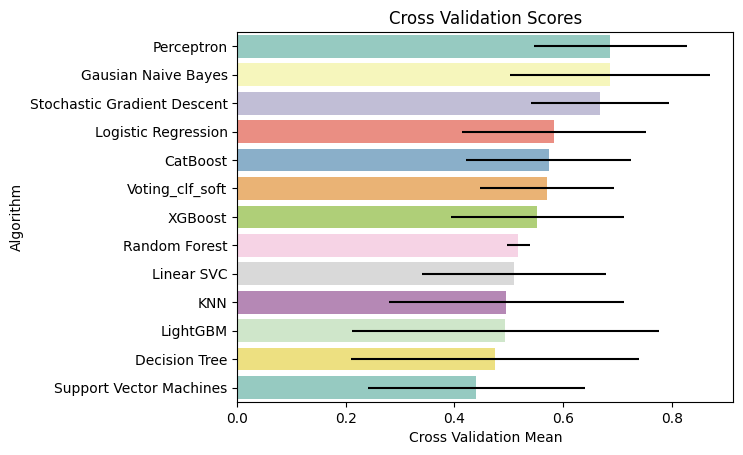

In [22]:
classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier(silent=True))
classifiers.append(LGBMClassifier())
classifiers.append(XGBClassifier())
classifiers.append(voting_clf_soft)


cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = 'roc_auc', cv = 5))

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 
                       'Cross Validation Std': cv_std, 
                       'Algorithm': ['Logistic Regression', 'Support Vector Machines',
                                     'KNN', 'Gausian Naive Bayes', 
                                     'Perceptron', 'Linear SVC', 
                                     'Stochastic Gradient Descent', 'Decision Tree', 
                                     'Random Forest', 'CatBoost', 
                                     'LightGBM', 'XGBoost',
                                     'Voting_clf_soft']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

sns.barplot(x='Cross Validation Mean', y='Algorithm', 
            data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', 
                                                      ascending = False)['Algorithm'], 
            palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

result = cv_res.sort_values('Cross Validation Mean', ascending=False).reset_index()
a, sc,st =  result['Algorithm'][0], result['Cross Validation Mean'][0], result['Cross Validation Std'][0]
print(f'Algorithm: {a}, Score: {sc}, Std: {st}')

## Тест

In [23]:
model = voting_clf_soft #GaussianNB().fit(X_train_scale,y_train)

predicted_train = model.predict(X_train)
print("Матрица ошибок")
print("Размер:",y_train.shape[0])
print("Соотношение")
print(y_train.value_counts())
print(confusion_matrix(y_train,predicted_train))

Матрица ошибок
Размер: 225
Соотношение
0    213
1     12
Name: target, dtype: int64
[[213   0]
 [ 12   0]]


DummyClassifier: 0.97
0    0.953333
1    0.046667
Name: target, dtype: float64

AUC-ROC: 0.73


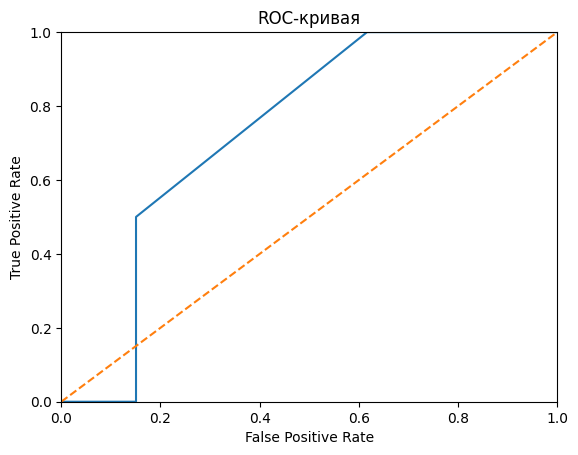

CPU times: total: 641 ms
Wall time: 131 ms


In [24]:
%%time
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

clf = DummyClassifier(strategy='most_frequent', random_state=5)
clf.fit(X_train, y_train)
print("DummyClassifier: %.2f" % clf.score(X_test, y_test))
print(data['target'].value_counts() / data.shape[0])
print()

probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print("AUC-ROC: %.2f" % auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()